# Case Study III: Poisson's equation

In the first two parts of the case study we solved the Laplace equation (no charges inside). We now add charges to solve the full Poisson equation and see how we recover the charge density.


In [1]:
import numpy as np

## Recap: Solving Laplace's equation

**Laplace's equation** for the electric potential $\Phi(\mathbf{r})$ without any charge density $\rho(\mathbf{r})$:

$$
\nabla^2 \Phi(x, y, z) = 0
$$

General solution by iteration:

$$
\Phi_{i,j} = \frac{1}{4}\Big(\Phi_{i+1,j} + \Phi_{i-1,j} + \Phi_{i,j+1} + \Phi_{i,j-1}\Big)
$$

### Jacobi method for Laplace's equation (NumPy)
Do not change $\Phi_{i,j}$ until a complete sweep has been completed.


Fast implementation using numpy array operations (vectorized, run at C speed, not Python speed):

In [2]:
def Laplace_Jacobi(Phi):
    """One update in the Jacobi algorithm"""
    Phi[1:-1, 1:-1] = 0.25*(Phi[2:, 1:-1] + Phi[0:-2, 1:-1] + Phi[1:-1, 2:] + Phi[1:-1, 0:-2])
    return Phi

## Problem: Wire and charge
Add a positive charge and a negative charge in the box.

![wire and dipole in a box](wire_dipole_box.png)

Now we need to solve **Poisson's equation**.

$$
\nabla^2 \Phi(x, y, z) = -4\pi\rho(x, y, z)
$$

because we have charge _inside_ the boundaries.

Finite difference solution:

$$
\Phi_{i,j} = \frac{1}{4}\Big(\Phi_{i+1,j} + \Phi_{i-1,j} + \Phi_{i,j+1} + \Phi_{i,j-1}\Big)
     + \pi\rho_{i,j} \Delta^2
$$

### Poisson Solver 
Modify the Laplace solvers to now solve Poisson's equation: add the charge (defined in the array `rho`):

In [3]:
import numpy as np

def Poisson_Jacobi(Phi, rho, Delta=1.):
    """One update in the Jacobi algorithm for Poisson's equation"""    
    Phi[1:-1, 1:-1] = 0.25*(Phi[2:, 1:-1] + Phi[0:-2, 1:-1] + Phi[1:-1, 2:] + Phi[1:-1, 0:-2]) \
                      + np.pi * Delta**2 * rho[1:-1, 1:-1]
    return Phi

### Solution with Jacobi algorithm

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

Only execute the next line if you *don't* want interactive plotting (e.g., when exporting to LaTeX/PDF or html):

In [5]:
%matplotlib inline

#### Convience plotting functions. 
If you provide a filename then output is only written to a file and figures are close to conserve memory. This allows you to plot files in loops and later assemble them into movies using other programs such as ffmpeg, ImageMagick, mencoder, QuickTime 7, ...

In [6]:
def plot_contour(Phi, filename=None, zlabel=r"potential $\Phi$ (V)",
                 cmap=plt.cm.coolwarm):
    """Plot Phi as a contour plot.
    
    Arguments
    ---------
    Phi : 2D array
          potential on lattice
    filename : string or None, optional (default: None)
          If `None` then show the figure and return the axes object.
          If a string is given (like "contour.png") it will only plot 
          to the filename and close the figure but return the filename.
    cmap : colormap
          pick one from matplotlib.cm          
    """
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)

    x = np.arange(Phi.shape[0])
    y = np.arange(Phi.shape[1])
    X, Y = np.meshgrid(x, y)
    Z = Phi[X, Y]
    cset = ax.contourf(X, Y, Z, 20, cmap=cmap)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect(1)

    cb = fig.colorbar(cset, shrink=0.5, aspect=5)
    cb.set_label(zlabel)
    
    if filename:
        fig.savefig(filename)
        plt.close(fig)
        return filename
    else:
        return ax
    

def plot_surf(Phi, filename=None, offset=-20, zlabel=r'potential $\Phi$ (V)',
             elevation=40, azimuth=-65, cmap=plt.cm.coolwarm):
    """Plot Phi as a 3D plot with contour plot underneath.
    
    Arguments
    ---------
    Phi : 2D array
          potential on lattice
    filename : string or None, optional (default: None)
          If `None` then show the figure and return the axes object.
          If a string is given (like "contour.png") it will only plot 
          to the filename and close the figure but return the filename.
    offset : float, optional (default: 20)
          position the 2D contour plot by offset along the Z direction
          under the minimum Z value
    zlabel : string, optional
          label for the Z axis and color scale bar
    elevation : float, optional
          choose elevation for initial viewpoint
    azimuth : float, optional
          chooze azimuth angle for initial viewpoint
    cmap : colormap
          pick one from matplotlib.cm
    """
     
    x = np.arange(Phi.shape[0])
    y = np.arange(Phi.shape[1])
    X, Y = np.meshgrid(x, y)
    Z = Phi[X, Y]
        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X, Y, Z, rstride=2, cstride=2, linewidth=0.5, color="gray")
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, alpha=0.6)
    cset = ax.contourf(X, Y, Z, 20, zdir='z', offset=offset+Z.min(), cmap=cmap)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel(zlabel)
    ax.set_zlim(offset + Z.min(), Z.max())
    
    ax.view_init(elev=elevation, azim=azimuth)

    cb = fig.colorbar(surf, shrink=0.5, aspect=5)
    cb.set_label(zlabel)
    
    if filename:
        fig.savefig(filename)
        plt.close(fig)
        return filename
    else:
        return ax

#### Code

Solve the Poisson problem with the Jacobi algorithmbut now employing the Poisson solver.

The charges are represented as an array `rho` where each charge takes up a `2x2` area.

In [7]:
Nmax = 100
Max_iter = 30000
tol = 1e-3

Phi = np.zeros((Nmax, Nmax), dtype=np.float64)
Phi_old = np.zeros_like(Phi)
rho = np.zeros_like(Phi)

# initialize boundaries
# everything starts out zero so nothing special for the grounded wires
Phi[0, :] = 100     # wire at x=0 at 100 V
rho[25:27, 39:41] = 5.0 
rho[75:77, 39:41] = -5.0 

Delta = 1.0

for n_iter in range(Max_iter):
    Phi_old[:, :] = Phi
    Phi = Poisson_Jacobi(Phi, rho, Delta=Delta)
    DeltaPhi = np.linalg.norm(Phi - Phi_old)
    if DeltaPhi < tol:
        print("Poisson_Jacobi() converged in {0} iterations to {1}".format(n_iter+1, DeltaPhi))
        break
else:
    print("Poisson_Jacobi() did NOT converge in {0} iterations, DeltaPhi={1}".format(n_iter+1, DeltaPhi))

    

Poisson_Jacobi() converged in 13843 iterations to 0.000999525022090086


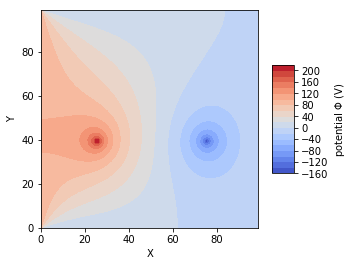

In [8]:
plot_contour(Phi)

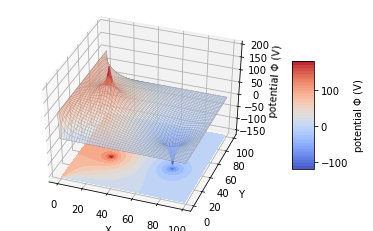

In [9]:
plot_surf(Phi, elevation=40, azimuth=-70)

## Charge density 
Given a potential $\Phi$, Poisson's equation gives the charge density:
$$
\rho(\mathbf{x}) = -\frac{1}{4\pi} \nabla^2\Phi(\mathbf{x})
$$

If we have the potential $\Phi$ (from our Poisson solver!) then we can calculate the charge density if we can represent the Laplace operator numerically.

We simply use the central difference approximation to get the discretized Laplacian

$$
\nabla^2 \Phi \approx \frac{\Phi(x+\Delta x,y) + \Phi(x-\Delta x,y) +\Phi(x,y+\Delta y) +\, \Phi(x,y-\Delta y) - 4\Phi(x, y)}{\Delta^2}
$$

or 

$$
[\nabla^2 \Phi]_{i,j} \approx \frac{\Phi_{i+1,j} + \Phi_{i-1,j} +\Phi_{i, j+1} +\, \Phi_{i,j-1} - 4\Phi_{i,j}}{\Delta^2}
$$

In [10]:
def laplacian2d(f, Delta=1):
    """Finite difference approximation of Del^2 f.
        
    Arguments
    ---------
    f : M x N matrix
    Delta : float
    
    Returns
    -------
    M x N matrix, boundaries set to 0
    """
    
    L = np.zeros_like(f, dtype=np.float64)
    L[1:-1, 1:-1] = f[1:-1, 2:] + f[1:-1, 0:-2] + f[2:, 1:-1] + f[0:-2, 1:-1] - 4*f[1:-1, 1:-1]
    return L/Delta**2


Compute the charge density from the converged potential
$$
\rho(x, y) = -\frac{1}{4\pi} \nabla^2 \Phi(x, y)
$$

In [11]:
rhox = - laplacian2d(Phi)/(4*np.pi)

Does `rhox` show the charges of $+5$ and $-5$ that we introduced with the charge density $\rho$?

In [12]:
print(rhox.min())
print(rhox.max())

-5.000004233123213
4.999995673166492


Indeed, the point charges are recovered from the potential.

Plot the charge density:

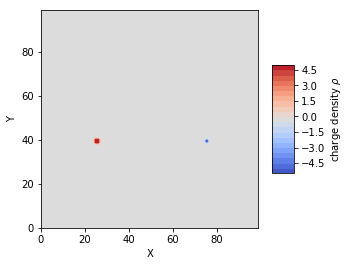

In [13]:
plot_contour(rhox, zlabel=r"charge density $\rho$")

The position of the point charges are found correctly but the charge on the wire appear to be absent. This is expected because the Laplacian is not defined on the boundary. If you wanted to see the charge on the wire you would need to include it inside the integration domain and also assign a thickness (e.g., one or two grid cells).

The 3D plot shows the "point" charges as spikes of the size of one grid cell:

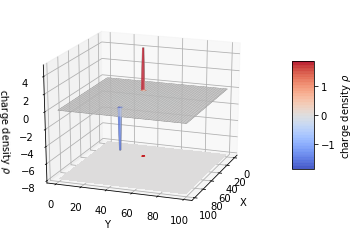

In [14]:
plot_surf(rhox, zlabel=r"charge density $\rho$", elevation=20, azimuth=20, offset=-3)

The position of the point charges are found correctly but the charge on the wire appear to be absent. The problem is that the Laplacian is not defined on the boundary.

Also, if the charges are only defined on a single grid cell then the 3D visualization is sometimes not able to show it correctly.